# COMPUTATIONAL STATISTICS : LAB 4 

Ruben Cardoso.

In [43]:
#Import libraries : 

import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf
from numpy.random import default_rng
from dataclasses import dataclass
import scipy as sp
from matplotlib.colors import LogNorm

## Exercise 1 : 

### Q1

We define the Markov transition kernel
$$
P = \frac{1}{2}\,(P_1 + P_2),
$$
where $P_i$ updates only the $i$-th coordinate. 


This algorithm is called a Random Scan Gibbs sampler because, at each iteration, one coordinate is chosen at random with probability 1/2.
Only the selected component is updated, while the other one remains unchanged. This is a Gibbs-type scheme since updates are performed coordinate-wise. So according to the course notes, we are effectively taking a permutation $\sigma$ from $(1,2)$ such that we sample $P_{\sigma(i)}$ each at a time. 

Metropolis–Hastings is used inside each coordinate update because the full conditional distributions
$$
\pi(x \mid y), \qquad \pi(y \mid x)
$$
are not sampled directly. Instead, a symmetric Gaussian random-walk proposal is used.

Without loss of generality, if coordinate $i=1$ is selected, we propose
$$
x' = x + \varepsilon, \qquad \varepsilon \sim \mathcal N(0,\sigma_1^2),
$$
and keep $y$ fixed.  

Since the proposal distribution is symmetric, the Metropolis–Hastings acceptance probability is
$$
\alpha = \min\!\left(1,\frac{\pi(x',y)}{\pi(x,y)}\right)
\quad\text{or}\quad
\alpha = \min\!\left(1,\frac{\pi(x,y')}{\pi(x,y)}\right),
$$
depending on which coordinate is updated.

___

In [2]:
## Q2 : 

#Sample P_1(z,.) for z in R^2.

def log_pi(x,y,a):
    """
    log(pi(x,y)) up to an additive constant. This transformation makes the computations easier. 
    """ 
    u=(x**2)/(a**2)-y**2
    return -(x**2)/(a**2)-(y**2)-0.25*(u**2)

def P_1(z,a,s_1,rng=None):
    """
    One step from P1(z,·): update x only via RW-MH with N(0, (s_1)^2), keep y fixed.
    """
    if rng is None:
        rng=np.random.default_rng()
    x,y=float(z[0]),float(z[1])

    x_prop=x+rng.normal(0.0,s_1)
    #Metropolis Hasting proposal acceptance step : 
    log_alpha=log_pi(x_prop,y,a)-log_pi(x,y,a)
    if np.log(rng.uniform())<min(0.0,log_alpha):
        x=x_prop
    return np.array([x,y])

def P_2(z, a, s_2, rng=None):
    """
    One step from P2(z,·): update y only via RW-MH with N(0, (s_2)^2), keep x fixed.
    """
    if rng is None:
        rng = np.random.default_rng()
    x, y = float(z[0]), float(z[1])

    y_prop = y + rng.normal(0.0, s_2)
    log_alpha = log_pi(x, y_prop, a) - log_pi(x, y, a)
    if np.log(rng.uniform()) < min(0.0, log_alpha):
        y = y_prop
    return np.array([x, y])

def P(z, a, s_1, s_2, rng=None):
    """
    P = 1/2 (P1 + P2):
    with prob 1/2 do P1, else do P2.
    """
    if rng is None:
        rng = np.random.default_rng()
    if rng.uniform() < 0.5:
        return P_1(z, a, s_1, rng=rng)
    else:
        return P_2(z, a, s_2, rng=rng)


def markov_chain(n_steps, z0, a, s_1, s_2, rng=None):
    """
    Sample  a markov chain (Z_k)_{k=0..n_steps} with kernel P.
    Returns array of shape (n_steps+1, 2).
    """
    if rng is None:
        rng = np.random.default_rng()

    chain = np.zeros((n_steps + 1, 2), dtype=float)
    chain[0] = np.array(z0, dtype=float)

    z = chain[0].copy()
    for k in range(1, n_steps + 1):
        z = P(z, a, s_1, s_2, rng=rng)
        chain[k] = z
    return chain

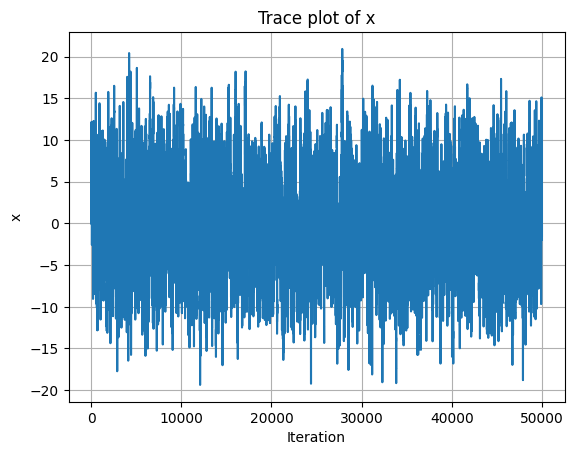

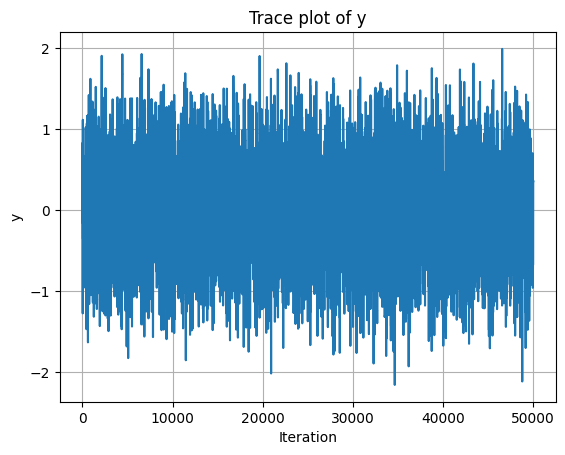

In [3]:
###Q3 : 

# Run the algorithm.
a = 10
s_1 = s_2 = 3
n_steps = 50_000
burnin = 5_000
z0 = (0.0, 0.0)

chain = markov_chain(n_steps, z0, a, s_1, s_2)
samples = chain[burnin:]

# Plot x
plt.figure()
plt.plot(chain[:, 0])
plt.title("Trace plot of x")
plt.xlabel("Iteration")
plt.ylabel("x")
plt.grid(True)
plt.show()

# Plot of y 
plt.figure()
plt.plot(chain[:, 1])
plt.title("Trace plot of y")
plt.xlabel("Iteration")
plt.ylabel("y")
plt.grid(True)
plt.show()




*The trace plot indicates good exploration of the state space, with no apparent drift or long-term trend. After burn-in, the chain appears to fluctuate around a stable distribution, suggesting stationarity.*


To evaluate the efficiency of the Markov chain, we use the autocorrelation
function (ACF), which was defined in the Time Series course. For a sequence
$(X_t)_{t\geq 0}$, the ACF measures the dependence between $X_t$ and $X_{t+h}$.
A slow decay of the ACF indicates strong dependence and poor mixing of the chain.


<Figure size 640x480 with 0 Axes>

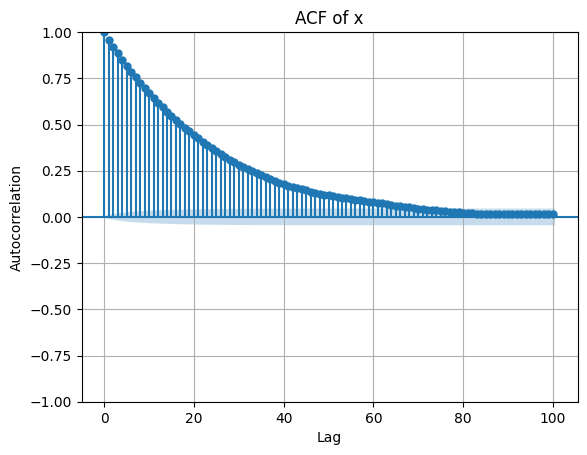

In [11]:
plt.figure()
plot_acf(samples[:, 0], lags=100,fft=True)
plt.title("ACF of x")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()


The autocorrelation function of $x$ decays slowly, indicating strong dependence
between successive samples. This reveals poor mixing of the Markov chain and a
low effective sample size. The slow decay is due to large proposal variances,
which lead to frequent rejections.
___

### Q4 

The performance can be improved by tuning the random-walk proposal variances
$\sigma_1^2$ and $\sigma_2^2$. In the present setting, the chosen variances are
too large, which leads to low acceptance rates and strong autocorrelation.
Using smaller proposal variances would increase the acceptance rate and improve
the mixing of the chain.

To justify the effect of the proposal variance, consider one coordinate update
(with symmetric random-walk proposal). From a current state $z$, propose
$$
z' = z + \varepsilon, \qquad \varepsilon \sim \mathcal N(0,\sigma^2),
$$
and accept with probability
$$
\alpha(z,z')=\min\!\left(1,\frac{\pi(z')}{\pi(z)}\right)
=\min\!\left(1,\exp\big(\log\pi(z')-\log\pi(z)\big)\right).
$$
Let $\ell(z)=\log\pi(z)$. By a Taylor expansion around $z$,
$$
\ell(z+\varepsilon)-\ell(z)=\nabla \ell(z)^\top \varepsilon+\frac12\,\varepsilon^\top \nabla^2\ell(\tilde z)\,\varepsilon,
$$
for some $\tilde z$ in $\mathcal{B}(0,\varepsilon)$. Hence, when $\sigma$ is small,
$\varepsilon=O(\sigma)$ and therefore
$$
\ell(z+\varepsilon)-\ell(z)=O(\sigma),
\qquad\text{so}\qquad
\exp(\ell(z+\varepsilon)-\ell(z))=1+O(\sigma).
$$
It follows that $\alpha(z,z')\to 1$ in probability as $\sigma\to 0$, and thus the
average acceptance rate $\mathbb E[\alpha]$ increases when the proposal variance
$\sigma^2$ is reduced (at least locally, for smooth $\log\pi$).

Alternatively, one may replace the random-walk proposals by MALA, which uses
gradient information of $\log \pi$ and typically yields faster exploration.

___


<Figure size 640x480 with 0 Axes>

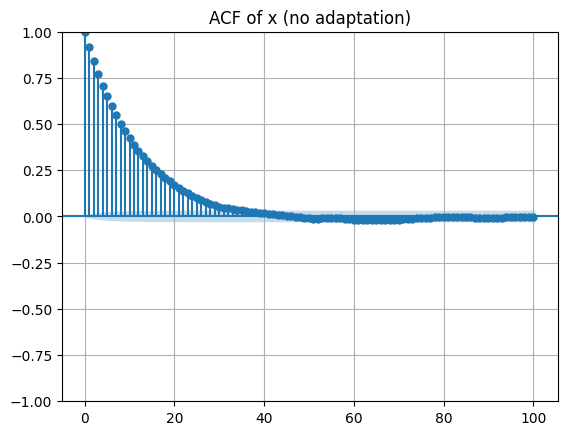

<Figure size 640x480 with 0 Axes>

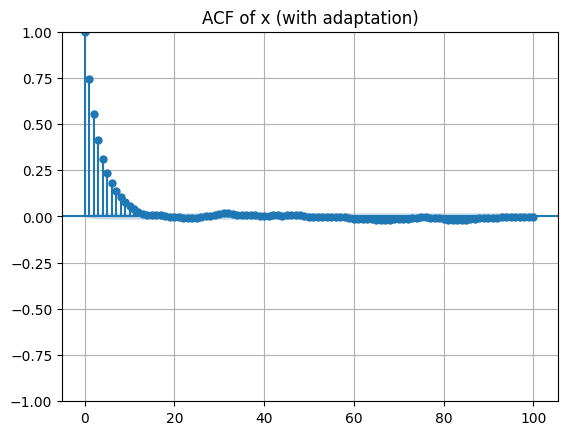

In [17]:
#Q5 : 

#Without adaptation : 

def fixed_scan_chain(n_steps, z0, a, s_1, s_2, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    chain = np.zeros((n_steps + 1, 2))
    chain[0] = z0
    z = np.array(z0, dtype=float)

    for k in range(1, n_steps + 1):
        z = P_1(z, a, s_1, rng=rng)
        z = P_2(z, a, s_2, rng=rng)
        chain[k] = z

    return chain

#With adaptation : 

def adaptive_fixed_scan_chain(n_steps, z0, a, batch=50, target=0.234, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    z = np.array(z0, dtype=float)
    chain = np.zeros((n_steps + 1, 2))
    chain[0] = z

    l1, l2 = 0.0, 0.0  # l_i = log(sigma_i)
    sig_hist = np.zeros((n_steps + 1, 2))
    sig_hist[0] = (np.exp(l1), np.exp(l2))

    acc1 = acc2 = 0
    n1 = n2 = 0

    for k in range(1, n_steps + 1):
        x, y = z
        s_1, s_2 = np.exp(l1), np.exp(l2)

        # update x
        x_prop = x + rng.normal(0.0, s_1)
        if np.log(rng.uniform()) < min(0.0, log_pi(x_prop, y, a) - log_pi(x, y, a)):
            x = x_prop
            acc1 += 1
        n1 += 1

        # update y
        y_prop = y + rng.normal(0.0, s_2)
        if np.log(rng.uniform()) < min(0.0, log_pi(x, y_prop, a) - log_pi(x, y, a)):
            y = y_prop
            acc2 += 1
        n2 += 1

        z = np.array([x, y])
        chain[k] = z
        sig_hist[k] = (s_1, s_2)

        if k % batch == 0:
            j = k // batch
            delta = min(0.05, j**(-0.5))
            l1 += delta if (acc1 / max(n1,1) > target) else -delta
            l2 += delta if (acc2 / max(n2,1) > target) else -delta
            acc1 = acc2 = n1 = n2 = 0

    return chain, sig_hist

#Run the algorithms: 

a = 10.0
n_steps = 50_000
burnin = 5_000
z0 = (0.0, 0.0)

rng = np.random.default_rng(0)
chain_no = fixed_scan_chain(n_steps, z0, a, s_1=3.0, s_2=3.0, rng=rng)

rng2 = np.random.default_rng(0)
chain_ad, sig_hist = adaptive_fixed_scan_chain(n_steps, z0, a, rng=rng2)

x_no = chain_no[burnin:, 0]
x_ad = chain_ad[burnin:, 0]


#acf to compare : 

plt.figure()
plot_acf(x_no[:], lags=100, fft=True)
plt.title("ACF of x (no adaptation)")
plt.grid(True)
plt.show()

plt.figure()
plot_acf(x_ad[:], lags=100, fft=True)
plt.title("ACF of x (with adaptation)")
plt.grid(True)
plt.show()

In [33]:
def first_lag_below_eps(x, max_lag=100, eps=0.05):
    # returns the smallest lag >= 1 such that |acf(lag)| <= eps
    r = acf(x, nlags=max_lag, fft=True)  # r[0]=1
    idx = np.where(np.abs(r[1:]) <= eps)[0]
    return (idx[0] + 1) if len(idx) > 0 else None, r

max_lag = 100
eps = 0.05

lag_no, acf_no = first_lag_below_eps(x_no, max_lag=max_lag, eps=eps)
lag_ad, acf_ad = first_lag_below_eps(x_ad, max_lag=max_lag, eps=eps)

print(f"epsilon = {eps}")
print("First lag with |ACF(lag)| <= eps (no adaptation):", lag_no)
print("First lag with |ACF(lag)| <= eps (with adaptation):", lag_ad)


epsilon = 0.05
First lag with |ACF(lag)| <= eps (no adaptation): 31
First lag with |ACF(lag)| <= eps (with adaptation): 11


To quantify mixing, we compute the first lag $\ell$ such that
$|\widehat\rho(\ell)| \le \varepsilon$ (here $\varepsilon=0.05$).
A smaller value indicates faster decorrelation.

**Thus, the ACF decays faster with adaptation, indicating improved mixing.**
___

In [30]:
#Q6 : 

#defining the parameters of the Banana curve: 

def log_fB(x, B=0.4):
    """
    Log-density of the banana-shaped distribution (up to a constant).
    """
    x = np.asarray(x)
    term1 = -0.5 * x[0]**2
    term2 = -0.5 * (x[1] + B * x[0]**2 - B)**2
    term3 = -0.5 * np.sum(x[2:]**2)
    return term1 + term2 + term3


#MH within Adaptative Gibbs : 

def adaptive_fixed_scan_chain_banana(
    n_steps, x0, B=0.4, batch=50, target=0.234, rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    d = len(x0)
    x = np.array(x0, dtype=float)

    chain = np.zeros((n_steps + 1, d))
    chain[0] = x

    # l_i = log(sigma_i)
    l = np.zeros(d)
    sig_hist = np.zeros((n_steps + 1, d))
    sig_hist[0] = np.exp(l)

    acc = np.zeros(d)
    n_acc = np.zeros(d)

    for k in range(1, n_steps + 1):
        for i in range(d):
            sigma = np.exp(l[i])
            x_prop = x.copy()
            x_prop[i] += rng.normal(0.0, sigma)

            log_alpha = log_fB(x_prop, B) - log_fB(x, B)
            if np.log(rng.uniform()) < min(0.0, log_alpha):
                x = x_prop
                acc[i] += 1
            n_acc[i] += 1

        chain[k] = x
        sig_hist[k] = np.exp(l)

        # adaptation
        if k % batch == 0:
            j = k // batch
            delta = min(0.05, j**(-0.5))
            rates = acc / np.maximum(n_acc, 1)
            l += np.where(rates > target, delta, -delta)
            acc[:] = 0
            n_acc[:] = 0

    return chain, sig_hist
    


<Figure size 640x480 with 0 Axes>

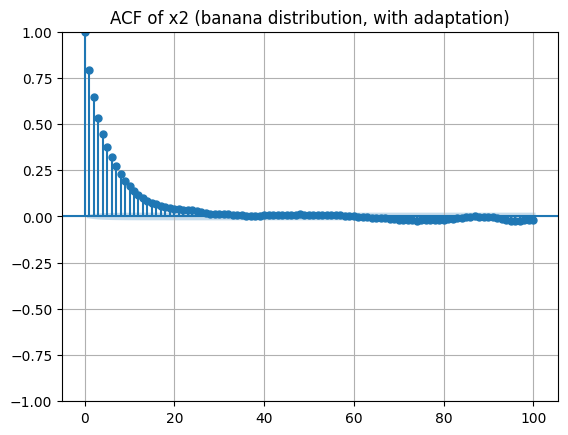

In [31]:
#Run the algorithms for Banana Shaped curve. 

d = 5
B = 0.4
n_steps = 50_000
burnin = 5_000

x0 = np.zeros(d)
rng = default_rng(0)

chain_banana, sig_hist = adaptive_fixed_scan_chain_banana(
    n_steps, x0, B=B, rng=rng
)

x1 = chain_banana[burnin:, 0]   
x2 = chain_banana[burnin:, 1]   

#plot the ACF : 

max_lag = 100

plt.figure()
plot_acf(x2[:], lags=max_lag, fft=True)
plt.title("ACF of x2 (banana distribution, with adaptation)")
plt.grid(True)
plt.show()


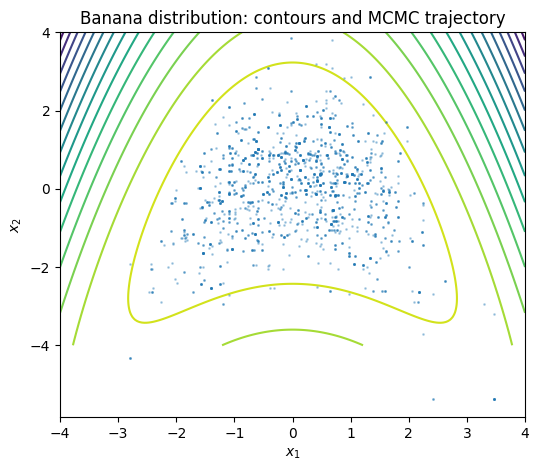

In [32]:
#Plotting as in the Figure 1 of the homework. 
# grid
xx = np.linspace(-4, 4, 200)
yy = np.linspace(-4, 4, 200)
X, Y = np.meshgrid(xx, yy)

Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = log_fB(np.array([X[i, j], Y[i, j], 0, 0, 0]), B=0.4)

plt.figure(figsize=(6, 5))
plt.contour(X, Y, Z, levels=15)

plt.plot(chain_banana[burnin:burnin+2000, 0],
         chain_banana[burnin:burnin+2000, 1],
         '.', alpha=0.3, markersize=2)

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Banana distribution: contours and MCMC trajectory")
plt.show()


**The central cluster represents samples in the high-density region around the mode, where the chain spends most of its time at stationarity.
The trajectory follows the curved high-density region of the banana
distribution, confirming effective exploration.**
___

# Exercise 2

In [41]:
# Q1:

def log_pi(x, mu, sigma, w):
    """
    log pi(x) for a Gaussian mixture with diagonal covariances.
    """
    x = np.atleast_2d(x)
    mu = np.asarray(mu)
    sigma = np.asarray(sigma)

    w = np.asarray(w, dtype=float)
    w = w / w.sum()

    n, d = x.shape

    diff = x[:, None, :] - mu[None, :, :]          # (n, K, d)
    z = diff / sigma[None, :, :]                   # (n, K, d)
    maha2 = np.sum(z**2, axis=-1)                  # (n, K)

    log_norm = -0.5 * (d * np.log(2*np.pi) + 2*np.sum(np.log(sigma), axis=1))  # (K,)
    comp = np.log(w)[None, :] + log_norm[None, :] - 0.5 * maha2               # (n, K)

    return sp.special.logsumexp(comp, axis=1)


def pi(x, mu, sigma, w):
    """pi(x) computed from log pi(x)."""
    return np.exp(log_pi(x, mu, sigma, w))


In [42]:
#Q2:

def mh_rw(log_target, x0, n_keep, step, burn=1000, seed=42):
    """
    Metropolis–Hastings with symmetric Gaussian random-walk proposal.
    """
    rng = np.random.default_rng(seed)

    x = np.asarray(x0, dtype=float).copy()
    d = x.size

    total = burn + n_keep
    out = np.empty((n_keep, d))

    logp = float(log_target(x.reshape(1, -1))[0])
    acc = 0

    for t in range(total):
        y = x + rng.normal(0.0, step, size=d)
        logp_y = float(log_target(y.reshape(1, -1))[0])

        if np.log(rng.random()) < (logp_y - logp):
            x = y
            logp = logp_y
            acc += 1

        if t >= burn:
            out[t - burn] = x

    return out, acc / total



In [62]:
#Q3 : 
#HM Fails to sample pi : 

log_target = lambda x: log_pi(x, mu=centers, sigma=sigmas, w=coeffs)

def count_modes(samples, centers, radius):
    d2 = ((samples[:, None, :] - centers[None, :, :])**2).sum(axis=2)
    return int((d2 <= radius**2).any(axis=0).sum())

step_sizes = [0.1, 0.5, 1.0, 2.0]
n_keep = 5000
burn = 500

radius = 3.0 * sigmas[0, 0]  # "near a mode"

rows = []

for step in step_sizes:
    samples, acc = mh_rw(
        log_target,
        x0=np.array([0.0, 0.0]),
        n_keep=n_keep,
        step=step,
        burn=burn,
        seed=42,
    )

    visited = count_modes(samples, centers, radius)

    rows.append({
        "step": step,
        "accept_rate": acc,
        "visited_modes": visited,
    })

results = pd.DataFrame(rows)
results


,step,accept_rate,visited_modes
0,0.1,0.596364,3
1,0.5,0.166545,3
2,1.0,0.038909,14
3,2.0,0.022909,20


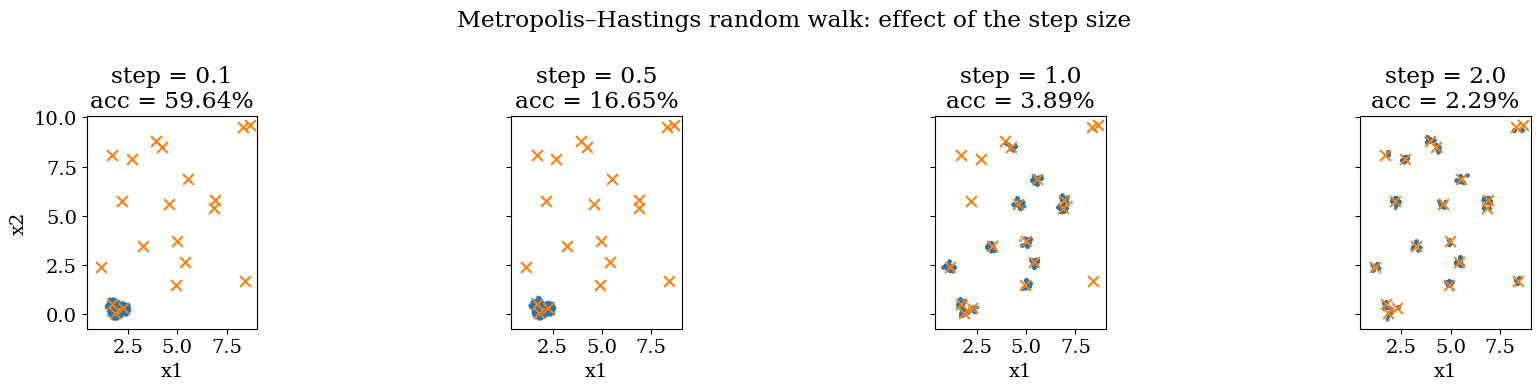

In [49]:
fig, axes = plt.subplots(1, len(step_sizes), figsize=(18, 4), sharex=True, sharey=True)

for ax, step in zip(axes, step_sizes):
    samples, acc = mh_rw(
        log_target,
        x0=np.array([0.0, 0.0]),
        n_keep=n_keep,
        step=step,
        burn=burn,
        seed=42,
    )

    ax.scatter(samples[:, 0], samples[:, 1], s=3, alpha=0.4)
    ax.scatter(centers[:, 0], centers[:, 1], marker="x", s=60)
    ax.set_title(f"step = {step}\nacc = {acc:.2%}")
    ax.set_aspect("equal")

axes[0].set_ylabel("x2")
for ax in axes:
    ax.set_xlabel("x1")

plt.suptitle("Metropolis–Hastings random walk: effect of the step size")
plt.tight_layout()
plt.show()


The figure shows the effect of the step size on the Metropolis–Hastings random walk.  
For small step sizes, the acceptance rate is high but the chain remains trapped in a local mode.  
For larger step sizes, more modes are reached, but the acceptance rate becomes very low, leading to poor mixing.

The table confirms this trade-off: high acceptance rates correspond to poor exploration, while better global exploration is achieved at the cost of very few accepted moves.

Overall, no choice of step size allows the Metropolis–Hastings random walk to efficiently sample from the multimodal target distribution $\pi$.
___

### Q4 :

For $T_1>1$, the tempered distribution is
$$
\pi_{T_1}(x)\ \propto\ \pi(x)^{1/T_1}.
$$
Since $1/T_1<1$, this transformation flattens the target distribution. Thus, Metropolis–Hastings proposals are accepted more often when moving between modes, making sampling easier.
___

In [59]:
#Q5 :

#Implement Parallel Tempering
def replica_exchange(logp_fn, start_points, n_keep, temp_ladder,
                     jump=0.5, warmup=1000, swap_every=10, rng_seed=42):
    """
    Parallel Tempering sampler.
    Returns samples from the chain at temperature T=1.
    """
    rng = np.random.default_rng(rng_seed)

    temp_ladder = np.asarray(temp_ladder, dtype=float)
    start_points = np.asarray(start_points, dtype=float)

    m, d = start_points.shape
    cold_id = int(np.argmin(np.abs(temp_ladder - 1.0)))  

    state = start_points.copy()                
    logp = logp_fn(state)                      

    total_iter = warmup + n_keep
    kept = np.empty((n_keep, d))

    acc_cold = 0

    for t in range(total_iter):
        # local MH moves at each temperature 
        for j in range(m):
            cand = state[j] + rng.normal(0.0, jump, size=d)
            cand_lp = float(logp_fn(cand.reshape(1, -1))[0])

            if np.log(rng.random()) < (cand_lp - logp[j]) / temp_ladder[j]:
                state[j] = cand
                logp[j] = cand_lp
                if j == cold_id:
                    acc_cold += 1

        #swap attempts between adjacent temperatures
        if (t + 1) % swap_every == 0:
            for j in range(m - 1):
                gain = (logp[j + 1] - logp[j]) * (1.0 / temp_ladder[j] - 1.0 / temp_ladder[j + 1])
                if np.log(rng.random()) < gain:
                    state[[j, j + 1]] = state[[j + 1, j]]
                    logp[[j, j + 1]] = logp[[j + 1, j]]

        #store cold chain after warmup 
        if t >= warmup:
            kept[t - warmup] = state[cold_id]

    return kept, acc_cold / total_iter


In [60]:
#Q6 : 

#Perform parallel tempering. 

temps = np.array([60, 21.6, 7.7, 2.8, 1.0])
starts = np.tile(np.array([0.0, 0.0]), (len(temps), 1))
logp_fn = lambda z: log_pi(z, mu=centers, sigma=sigmas, w=coeffs)

def pt_run(logp_fn, starts, temps, taus, n_keep=10_000, warmup=2000, swap_every=10, seed=42):
    rng = np.random.default_rng(seed)
    temps = np.asarray(temps, float)
    taus  = np.asarray(taus, float)

    m, d = starts.shape
    cold_id = int(np.argmin(np.abs(temps - 1.0)))

    state = starts.astype(float).copy()
    logp  = logp_fn(state)  # (m,)

    kept = np.empty((n_keep, d))
    acc_cold = 0
    total = warmup + n_keep

    for t in range(total):
        # local moves
        for j in range(m):
            cand = state[j] + rng.normal(0.0, taus[j], size=d)
            cand_lp = float(logp_fn(cand.reshape(1, -1))[0])

            if np.log(rng.random()) < (cand_lp - logp[j]) / temps[j]:
                state[j] = cand
                logp[j] = cand_lp
                if j == cold_id:
                    acc_cold += 1

        # swaps adjacent
        if (t + 1) % swap_every == 0:
            for j in range(m - 1):
                gain = (logp[j + 1] - logp[j]) * (1.0 / temps[j] - 1.0 / temps[j + 1])
                if np.log(rng.random()) < gain:
                    state[[j, j + 1]] = state[[j + 1, j]]
                    logp[[j, j + 1]]  = logp[[j + 1, j]]

        # keep cold chain after warmup
        if t >= warmup:
            kept[t - warmup] = state[cold_id]

    return kept, acc_cold / total

def count_modes(samples, centers, sigmas):
    # mode "visited" if we have at least one sample within radius = 3*sigma of a center
    r = 3.0 * float(sigmas[0, 0])
    d2 = ((samples[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)
    return int((d2 <= r * r).any(axis=0).sum())


tau_i = 1:           acc(T=1) = 3.98%, visited_modes = 20/20
tau_i = 0.25*sqrt(T): acc(T=1) = 25.32%, visited_modes = 20/20


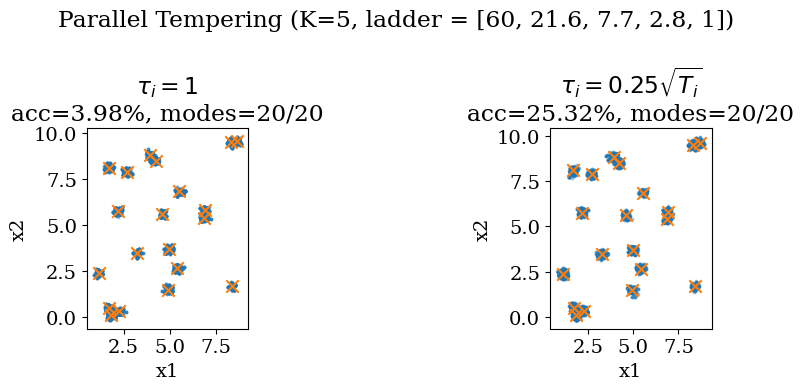

In [61]:
#Run the algorithms with given tau.

taus_A = np.ones_like(temps)                 # tau_i = 1
taus_B = 0.25 * np.sqrt(temps)               # tau_i = 0.25*sqrt(T_i)

sA, accA = pt_run(logp_fn, starts, temps, taus_A, n_keep=10_000, warmup=2000, swap_every=10, seed=42)
sB, accB = pt_run(logp_fn, starts, temps, taus_B, n_keep=10_000, warmup=2000, swap_every=10, seed=42)

mA = count_modes(sA, centers, sigmas)
mB = count_modes(sB, centers, sigmas)

print(f"tau_i = 1:           acc(T=1) = {accA:.2%}, visited_modes = {mA}/20")
print(f"tau_i = 0.25*sqrt(T): acc(T=1) = {accB:.2%}, visited_modes = {mB}/20")


plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.set_aspect("equal")
ax1.scatter(sA[:, 0], sA[:, 1], s=3, alpha=0.35)
ax1.scatter(centers[:, 0], centers[:, 1], marker="x", s=80)
ax1.set_title(r"$\tau_i=1$" + f"\nacc={accA:.2%}, modes={mA}/20")
ax1.set_xlabel("x1"); ax1.set_ylabel("x2")

ax2 = plt.subplot(1, 2, 2)
ax2.set_aspect("equal")
ax2.scatter(sB[:, 0], sB[:, 1], s=3, alpha=0.35)
ax2.scatter(centers[:, 0], centers[:, 1], marker="x", s=80)
ax2.set_title(r"$\tau_i=0.25\sqrt{T_i}$" + f"\nacc={accB:.2%}, modes={mB}/20")
ax2.set_xlabel("x1"); ax2.set_ylabel("x2")

plt.suptitle("Parallel Tempering (K=5, ladder = [60, 21.6, 7.7, 2.8, 1])")
plt.tight_layout()
plt.show()


**Parallel Tempering with $K=5$ and the prescribed temperature ladder allows the cold chain ($T=1$) to explore all modes of the target distribution. The choice $\tau_i=0.25\sqrt{T_i}$ leads to a significantly higher acceptance rate than $\tau_i=1$, while maintaining full mode exploration !**